# Cyber Risk Sentiment Analysis using Natural Language Processing

This project focuses on analyzing sentiment related to **cyber risk** discussions using **Natural Language Processing (NLP)** techniques. By collecting Reddit posts from subreddits centered around cybersecurity topics like cyber attacks, ransomware, and data breaches, the objective is to classify these posts into **Positive**, **Negative**, or **Neutral** sentiment categories. This analysis will help to gain insights into the public sentiment surrounding **cyber risk** and provide a better understanding of how people discuss cybersecurity-related threats and issues online.

To accomplish this, two **NLP** models will be applied: **VADER**, a lexicon-based model designed for analyzing sentiment in short texts like social media posts, and **BERT (DistilBERT)**, a fine-tuned deep learning model for sentiment analysis. The project will involve collecting, cleaning, and preprocessing data, followed by applying both models to classify sentiment. A comparative analysis of the results will assess how well each model detects **cyber risk** sentiment. Additionally, the project will feature visualizations to help interpret sentiment trends and better understand how **cyber risk** is perceived in online conversations.

# Table of Contents

1. [Importing Necessary Libraries](#Importing-Necessary-Libraries)
2. [Data Collection Via Reddit](#Data-Collection-Via-Reddit)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Sentiment Analysis Using Vader](#Sentiment-Analysis-Using-Vader)
5. [Data Visualization and Insights](#Data-Visualization)
6. [BERT for Sentiment Analysis](#BERT-for-Sentiment-Analysis)
7. [Model Comparision](#Model-Comparision)

# Importing Necessary Libraries

In [10]:
import praw  # Reddit API wrapper to interact with Reddit data
import pandas as pd  # Data manipulation and analysis
import re  # Regular expressions for text processing
import nltk  # Natural Language Toolkit for text processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Sentiment analysis using VADER
from nltk.corpus import stopwords  # List of stop words for text cleaning
from nltk.stem import WordNetLemmatizer  # Lemmatization for word normalization
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorizing text for machine learning
from textblob import TextBlob  # Simple NLP tasks, including sentiment analysis
import matplotlib.pyplot as plt  # Data visualization 
from wordcloud import WordCloud  # Generating word clouds from text data
from sklearn.feature_extraction.text import CountVectorizer  # Text vectorization based on word frequency
from transformers import pipeline  # Hugging Face pipeline for NLP tasks
from dotenv import load_dotenv #For Api credentials
import os
import warnings

# Required for NLP tasks
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')

#styling
plt.style.use('seaborn-v0_8')

# Ignore all warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jainn\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jainn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jainn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Collection Via Reddit

To gather relevant data for analyzing cybersecurity discussions, we use Reddit's API to collect posts from specific subreddits related to cybersecurity. The target subreddits include 'cybersecurity', 'netsec', 'infosec', 'AskNetsec', and 'ThreatIntel', and the posts are filtered based on a set of keywords such as 'ransomware', 'data breach', 'phishing', and more.

The script fetches the top 100 posts from each subreddit, checking both the title and body text for the presence of any relevant keywords. For each relevant post, details such as title, URL, body text, and post date are collected. After gathering the data, it's stored in a DataFrame and saved as a CSV file for further analysis.

In [11]:
# Load the environment variables from .env file
load_dotenv()

reddit_api_key = os.getenv('client_id')
reddit_secret_key = os.getenv('client_secret')
user_agent = "my_reddit_app:1.0 (by /u/Nimo)"


# Initializing Reddit instance with client credentials
reddit = praw.Reddit(
    client_id=reddit_api_key, #Client ID for accessing the Reddit API
    client_secret=reddit_secret_key, #Client Secret for authentication
    user_agent=user_agent #user agent to identify the app to Reddit
)

In [12]:
# Defining target subreddits and keywords for monitoring relevant topics
subreddits = ['cybersecurity', 'netsec', 'infosec', 'AskNetsec', 'ThreatIntel']
keywords = ['cybersecurity', 'cyber attack', 'ransomware', 'data breach', 'phishing', 'vulnerability', 'hacking', 'malware', 'cyber risk', 'infosec','Cyber Insurance']

# Collecting data
posts_data = []
for subreddit_name in subreddits:
    try:
        subreddit = reddit.subreddit(subreddit_name)
        for post in subreddit.top(limit=1000):  # Limit to top 1000 posts
            title = post.title
            url = post.url
            selftext = post.selftext if post.selftext else ''  # Handle posts with no selftext
            post_date = post.created_utc
            # Search for relevant keywords in post title and body
            if any(keyword.lower() in (title + ' ' + selftext).lower() for keyword in keywords):
                posts_data.append({
                    'Title': title,
                    'URL': url,
                    'Body': selftext,
                    'Date': post_date,
                })
    except Exception as e:
        print(f"Error collecting data from subreddit {subreddit_name}: {e}")

# Converting to DataFrame
df = pd.DataFrame(posts_data)

# Save the data to a CSV file
df.to_csv('cybersecurity_reddit_posts.csv', index=False)

print(f"Collected {len(df)} posts related to cybersecurity.")

Collected 959 posts related to cybersecurity.


# Data Preprocessing 


This section focuses on cleaning the Reddit post data. The script loads the data, initializes a **lemmatizer** for word normalization, and defines **stopwords** for filtering out common, non-informative words.

The `preprocess_text` function performs several tasks:
- Removes **URLs**, **mentions**, and **special characters**.
- Converts text to **lowercase**.
- **Tokenizes** the text and removes **stopwords**.
- **Lemmatizes** the words to their base form.

The function is applied to the post bodies, generating a cleaned version of the text for further analysis.

In [13]:
# Load the data
df = pd.read_csv('cybersecurity_reddit_posts.csv')

# Initializing the lemmatizer and defining stop words
lemmatizer = WordNetLemmatizer() # Reduces words to their base form
stop_words = set(stopwords.words('english'))

# Function for cleaning and preprocessing text
def preprocess_text(text):
    if not isinstance(text, str):  
        text = str(text)  
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove mentions (@usernames)
    text = re.sub(r'@\w+', '', text)
    
    # Remove special characters and digits
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return the cleaned text
    return ' '.join(tokens)

# Applying the preprocessing function to the posts
df['Cleaned_Text'] = df['Body'].apply(preprocess_text)

# Sentiment Analysis Using Vader

In this section, we perform sentiment analysis on the cleaned Reddit post text using the **VADER SentimentIntensityAnalyzer**. VADER is well-suited for analyzing social media text and short online comments, as it is designed to handle informal language, emoticons, slang, and capitalization commonly found in such content.

The `get_vader_sentiment` function calculates the **compound sentiment score** for each post, which reflects the overall sentiment polarity. Based on the compound score:
- **Positive** sentiment is assigned if the score is greater than 0.
- **Negative** sentiment is assigned if the score is less than 0.
- **Neutral** sentiment is assigned if the score is 0.

The sentiment scores and labels are then added to the DataFrame, and the results are saved to a CSV file for further analysis.

In [14]:
# Initializing the VADER SentimentIntensityAnalyzer.
sia = SentimentIntensityAnalyzer()

# Function to calculate the sentiment score of text using VADER, returning a compound score representing overall sentiment polarity.
def get_vader_sentiment(text):
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']  

# Applying the sentiment analysis
df['Sentiment_Score'] = df['Cleaned_Text'].apply(get_vader_sentiment)

# Classifying sentiment as positive, neutral, or negative based on the compound score
df['Sentiment_Label'] = df['Sentiment_Score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Save the result to a CSV file
df.to_csv('cybersecurity_sentiment.csv', index=False)

display(df.head())

,Title,URL,Body,Date,Cleaned_Text,Sentiment_Score,Sentiment_Label
0,I've Curated a Massive Repo of Free Cybersecur...,https://www.reddit.com/r/cybersecurity/comment...,"Community,\n\nI've compiled a massive amount o...",1.613512e+09,community ive compiled massive amount free res...,0.9349,Positive
1,Malware packed in DNA.,https://i.redd.it/osgfjewxpai41.png,NaN,1.582299e+09,nan,0.0000,Neutral
2,23andMe confirms hackers stole ancestry data o...,https://techcrunch.com/2023/12/04/23andme-conf...,">In disclosing the incident in October, 23andM...",1.701778e+09,disclosing incident october andme said data br...,-0.2732,Negative
3,Hacking Tools Cheat Sheet,https://i.redd.it/fviaw8s43q851.jpg,NaN,1.593817e+09,nan,0.0000,Neutral
4,My thoughts on a decade of Cyber Security: 10 ...,https://www.reddit.com/r/cybersecurity/comment...,I’ve spent a little more than a decade working...,1.629650e+09,ive spent little decade working cyber starting...,0.9987,Positive



- **Positive Sentiment**: Posts classified as positive reflect optimism or confidence about **cybersecurity** measures or advancements. These might discuss new technologies, successful prevention of cyber threats, or positive actions taken to reduce **cyber risk**.

- **Negative Sentiment**: Posts with negative sentiment express concern, fear, or frustration related to **cyber risk**. These may highlight security breaches, vulnerabilities, or growing threats like ransomware and hacking that increase **cyber risk**.

- **Neutral Sentiment**: Neutral posts are neither overly positive nor negative. These could be informational, factual discussions or posts that present data without expressing strong opinions or emotions about **cybersecurity** or **cyber risk**.

# Data Visualization

## 1. Sentiment Distribution

This bar chart displays the sentiment distribution of Reddit posts on cybersecurity topics. Bars represent the count of posts labeled as positive (green), negative (red), or neutral (gray), showing the overall public sentiment towards cyber risks.

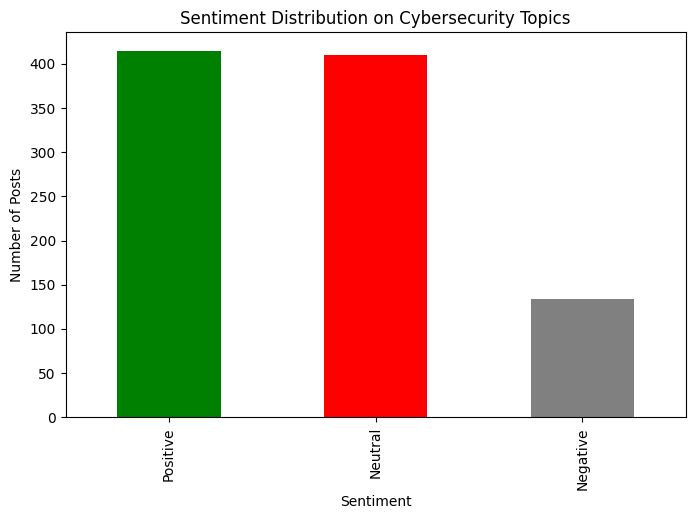

In [15]:
# Count the number of occurrences of each sentiment label (positive, negative, neutral)
sentiment_counts = df['Sentiment_Label'].value_counts()

plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("Sentiment Distribution on Cybersecurity Topics")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")
plt.show()

## 2. Word Cloud

These word clouds display the most common words in Reddit posts with **positive** and **negative** sentiment on cybersecurity topics. The **positive word cloud** highlights frequently used terms in posts labeled as positive, while the **negative word cloud** shows prominent words in posts labeled as negative. Larger words appear more frequently, offering a quick view of key topics and sentiments discussed within each sentiment category.

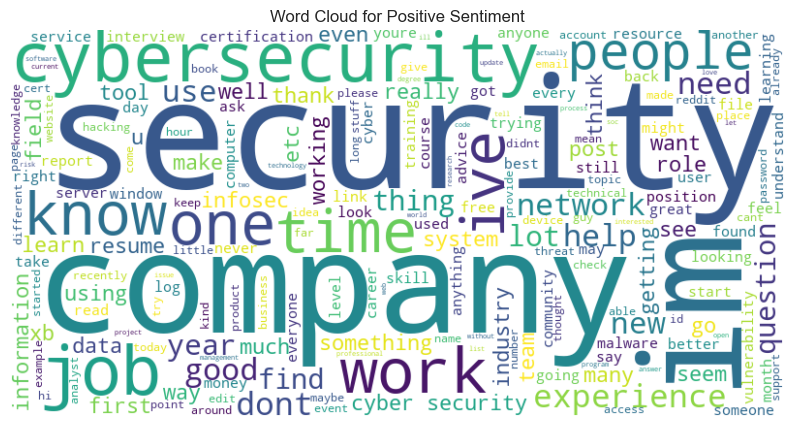

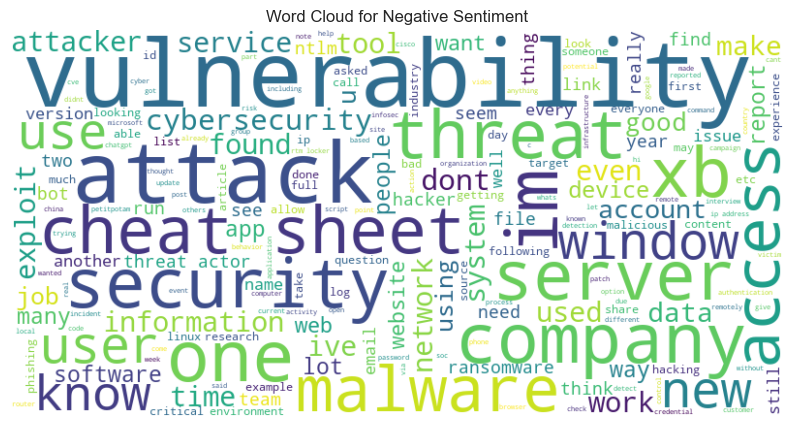

In [51]:
# Positive sentiment word cloud
positive_words = ' '.join(df[df['Sentiment_Label'] == 'Positive']['Cleaned_Text'])
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title("Word Cloud for Positive Sentiment")
plt.axis('off')
plt.show()

# Negative sentiment word cloud
negative_words = ' '.join(df[df['Sentiment_Label'] == 'Negative']['Cleaned_Text'])
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title("Word Cloud for Negative Sentiment")
plt.axis('off')
plt.show()

This code identifies the most frequently discussed keywords associated with positive and negative sentiments in cybersecurity-related posts. By analyzing these top terms, we can gain insights into specific topics that drive each type of sentiment.

- Uses `CountVectorizer` to filter out stop words and capture the 10 most frequent words per sentiment.
- Creates frequency tables displaying each keyword alongside its count for both positive and negative sentiments.
- Highlights key themes discussed in positive versus negative sentiment posts, offering insights into public perception of cybersecurity topics.

## 3. Top Keywords by Sentiment

In [17]:
# Create a CountVectorizer for each sentiment category
vectorizer = CountVectorizer(stop_words='english', max_features=10)

# Positive sentiment keywords
positive_text = df[df['Sentiment_Label'] == 'Positive']['Cleaned_Text']
positive_vectorized = vectorizer.fit_transform(positive_text)
positive_keywords = vectorizer.get_feature_names_out()
positive_counts = positive_vectorized.sum(axis=0).A1
positive_keywords_df = pd.DataFrame(list(zip(positive_keywords, positive_counts)), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

# Negative sentiment keywords
negative_text = df[df['Sentiment_Label'] == 'Negative']['Cleaned_Text']
negative_vectorized = vectorizer.fit_transform(negative_text)
negative_keywords = vectorizer.get_feature_names_out()
negative_counts = negative_vectorized.sum(axis=0).A1
negative_keywords_df = pd.DataFrame(list(zip(negative_keywords, negative_counts)), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)

print("Top Positive Keywords:")
print(positive_keywords_df.head(10))
print("\nTop Negative Keywords:")
print(negative_keywords_df.head(10))

Top Positive Keywords:
            Word  Count
9       security    553
4             im    348
8           like    309
2  cybersecurity    270
6            job    256
0        company    247
7           know    221
3           dont    211
1          cyber    210
5            ive    208

Top Negative Keywords:
            Word  Count
8  vulnerability     82
0         attack     71
7         threat     67
6       security     62
4           like     49
1        company     47
2             im     46
3           know     43
9             xb     43
5        malware     42


## 4. Sentiment Trends Over Time

This code converts UNIX timestamps into a human-readable datetime format and extracts the year for temporal aggregation. The groupby operation aggregates sentiment counts for each year and sentiment type (Positive, Negative, Neutral). The stacked bar chart is generated to visualize how sentiment distributions evolve across years, allowing us to analyze trends such as changes in sentiment over time (e.g., shifts towards more negativity or positivity). /

<Figure size 1400x700 with 0 Axes>

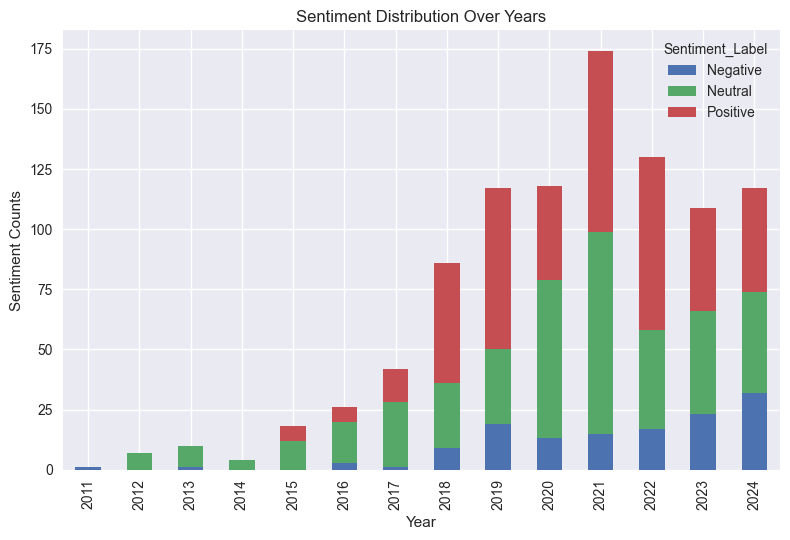

In [50]:
df['Date'] = pd.to_datetime(df['Date'], unit='s')  # Date is in UNIX timestamp
df['Year'] = df['Date'].dt.year 

# Counting occurrence of each sentiment for each year
sentiment_counts_yearwise = df.groupby(['Year', 'Sentiment_Label']).size().unstack(fill_value=0)

# stacked bar chart
plt.figure(figsize=(14, 7))
sentiment_counts_yearwise.plot(kind='bar', stacked=True)
plt.ylabel("Sentiment Counts")
plt.xlabel("Year")
plt.title("Sentiment Distribution Over Years")
plt.legend(title='Sentiment_Label')
plt.tight_layout()
plt.show()


# BERT for Sentiment Analysis

In this section, we perform sentiment analysis using a **fine-tuned BERT model** from the Hugging Face library. The model used is **distilbert-base-uncased-finetuned-sst-2-english**, which is a version of BERT specifically fine-tuned on the **SST-2 (Stanford Sentiment Treebank)** dataset. This model is capable of classifying text into **positive** or **negative** sentiments, making it ideal for analyzing sentiment in text, including social media posts.

BERT (Bidirectional Encoder Representations from Transformers) works by considering the **context of words** from both directions in a sentence (left and right), which allows it to capture more nuanced meanings compared to traditional models. In this case, the model is particularly effective at understanding the sentiment of short, informal text, such as the content found in Reddit posts.

The function `bert_sentiment` takes the **Cleaned_Text** of each post, applies the BERT model, and returns the sentiment label as **positive** or **negative**. The text is tokenized and padded to a maximum length of 512 tokens to ensure compatibility with the model's input requirements. The sentiment labels are then stored in a new column, `sentiment_bert`, for further analysis.

In [52]:
# Initializing a sentiment analysis pipeline with a DistilBERT model fine-tuned for sentiment tasks.
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

In [53]:
#Function to perform sentiment analysis using the fine-tuned BERT model, applying it to the 'Cleaned_Text'.
def bert_sentiment(text):
    result = sentiment_analyzer(text, truncation=True, padding=True, max_length=512)
    return result[0]['label'].lower()

#Column and storing the sentiment label in 'sentiment_bert'.
df['sentiment_bert'] = df['Cleaned_Text'].apply(bert_sentiment)

# Model Comparision

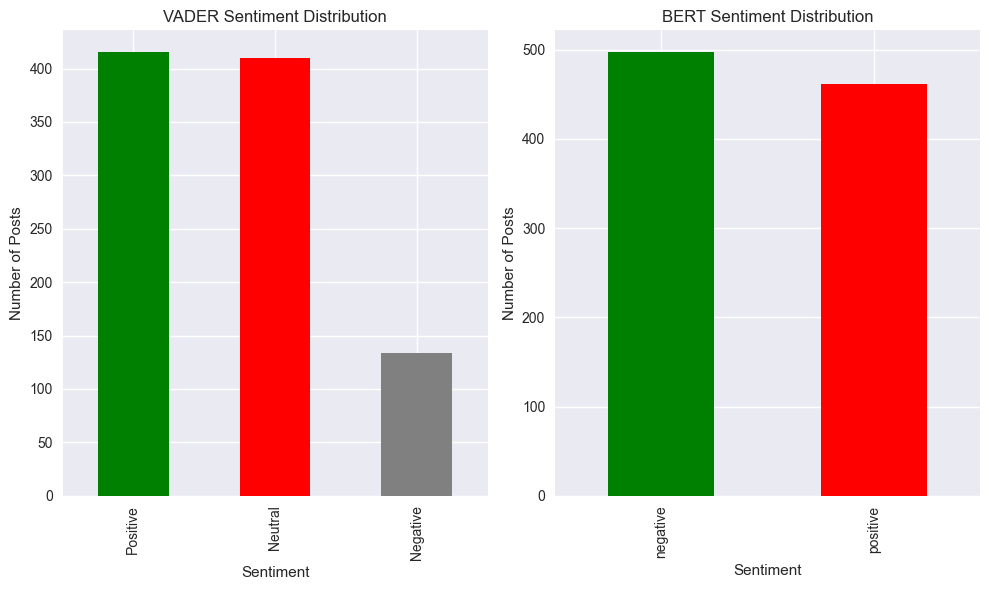

In [54]:
# Get sentiment counts for VADER
sentiment_counts_vader = df['Sentiment_Label'].value_counts()

# Get sentiment counts for BERT
sentiment_counts_bert = df['sentiment_bert'].value_counts()

# Create a side-by-side bar plot for comparison
plt.figure(figsize=(10, 6))

# Plot VADER sentiment distribution
plt.subplot(1, 2, 1)
sentiment_counts_vader.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")

# Plot BERT sentiment distribution
plt.subplot(1, 2, 2)
sentiment_counts_bert.plot(kind='bar', color=['green', 'red', 'gray'])
plt.title("BERT Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Posts")

plt.tight_layout()
plt.show()

In [55]:
# Get sentiment counts for VADER
sentiment_counts_vader = df['Sentiment_Label'].value_counts()

# Get sentiment counts for BERT
sentiment_counts_bert = df['sentiment_bert'].value_counts()

print(sentiment_counts_vader)
print(sentiment_counts_bert)

Sentiment_Label
Positive    415
Neutral     410
Negative    134
Name: count, dtype: int64
sentiment_bert
negative    497
positive    462
Name: count, dtype: int64


From this comparison, We infer that:

- **VADER** tends to categorize a larger portion of posts as **Neutral**, which might indicate that it is more conservative or cautious in assigning clear sentiment, especially with text that has mixed or subtle tones.
  
- **BERT**, with its deep learning capabilities, provides more **decisive** sentiment labels, leaning towards **Positive** and **Negative** classifications, which suggests that it is better at capturing stronger sentiments or more polarized opinions in the data.

- This difference highlights that VADER is better suited for general sentiment detection in informal contexts, while BERT’s ability to understand context in greater depth allows it to more confidently classify posts into distinct sentiment categories.